<a href="https://colab.research.google.com/github/sayevvv/PBL_MoneyClassification/blob/main/PBL_preprocessing1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PBL - MONEY DETECTION

#PREPROCESSING DATA
 - Feature Extraction : Color Histogram

In [ ]:
# -----------------------------------------------------
# LANGKAH 1: IMPORT LIBRARY DAN MOUNT DRIVE
# -----------------------------------------------------
import os
import cv2
import numpy as np
import joblib  # Untuk menyimpan hasil
from tqdm import tqdm  # Untuk progress bar
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive Anda
# Anda harus melakukan autentikasi
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -----------------------------------------------------
# LANGKAH 2: KONFIGURASI DAN DEFINISI VARIABEL
# -----------------------------------------------------

# Tentukan path utama tempat folder dataset Anda berada
# --- PATH TELAH DIPERBARUI ---
BASE_DIR = '/content/drive/MyDrive/tugas_akhir_semester5/raw_data'

# Tentukan label kelas (HARUS SAMA DENGAN NAMA FOLDER)
# Saya asumsikan Anda memiliki 7 denominasi
LABELS = ['1000', '2000', '5000', '10000', '20000', '50000', '100000']

# Tentukan ukuran preprocessing
# Semua gambar akan diubah ke ukuran ini
IMG_SIZE = (250, 250)

# Tentukan jumlah "bin" (level) untuk histogram
# H (Hue) memiliki rentang 0-179 di OpenCV
# S (Saturation) memiliki rentang 0-255
H_BINS = 180
S_BINS = 256

# Ekstensi file yang diizinkan (didefinisikan di sini agar global)
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

print(f"Path utama diatur ke: {BASE_DIR}")
print(f"Kelas yang akan diproses: {LABELS}")

Path utama diatur ke: /content/drive/MyDrive/tugas_akhir_semester5/raw_data
Kelas yang akan diproses: ['1000', '2000', '5000', '10000', '20000', '50000', '100000']


In [ ]:
# -----------------------------------------------------
# LANGKAH 3: FUNGSI EKSTRAKSI FITUR
# -----------------------------------------------------
def extract_features(image_path):
    """
    Fungsi ini mengambil satu path gambar, melakukan semua
    preprocessing, dan mengekstrak fitur histogram H+S.
    """
    try:
        # 1. Baca gambar
        image = cv2.imread(image_path)

        # Jika gambar tidak bisa dibaca (file korup)
        if image is None:
            print(f"Peringatan: Tidak bisa membaca gambar {image_path}. Dilewati.")
            return None

        # --- PREPROCESSING GAMBAR ---

        # 2. Menyamakan Ukuran (Resize)
        image = cv2.resize(image, IMG_SIZE)

        # 3. Perhalus (Gaussian Blur) untuk mengurangi noise
        image = cv2.GaussianBlur(image, (5, 5), 0)

        # 4. Konversi Ruang Warna ke HSV (SANGAT PENTING)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # --- EKSTRAKSI FITUR ---

        # 5. Hitung histogram untuk channel H (Hue)
        h_hist = cv2.calcHist([hsv_image], [0], None, [H_BINS], [0, 180])

        # 6. Hitung histogram untuk channel S (Saturation)
        s_hist = cv2.calcHist([hsv_image], [1], None, [S_BINS], [0, 256])

        # 7. Normalisasi histogram (opsional, tapi bagus untuk SVM)
        cv2.normalize(h_hist, h_hist, 0, 1, cv2.NORM_MINMAX)
        cv2.normalize(s_hist, s_hist, 0, 1, cv2.NORM_MINMAX)

        # 8. Gabungkan kedua histogram menjadi satu vektor fitur
        feature_vector = np.concatenate((h_hist, s_hist))

        # 9. Ratakan (flatten) vektor agar menjadi 1D
        feature_vector = feature_vector.flatten()

        return feature_vector

    except Exception as e:
        print(f"Error memproses {image_path}: {e}")
        return None

In [ ]:
# -----------------------------------------------------
# LANGKAH 4: (BARU) CEK KESEIMBANGAN DATA
# -----------------------------------------------------

print("\nMemulai pengecekan keseimbangan data...")
data_counts = {}
total_images = 0

for label in LABELS:
    label_path = os.path.join(BASE_DIR, label)
    if not os.path.isdir(label_path):
        print(f"Info: Folder {label_path} tidak ada, dilewati.")
        data_counts[label] = 0
        continue

    count = 0
    for file in os.listdir(label_path):
        if file.lower().endswith(VALID_EXTENSIONS):
            count += 1

    data_counts[label] = count
    total_images += count

print("\n--- Laporan Keseimbangan Data ---")
if total_images == 0:
    print("PERINGATAN: Tidak ada gambar yang ditemukan! Cek BASE_DIR dan nama folder Anda.")
else:
    for label, count in data_counts.items():
        percentage = (count / total_images) * 100 if total_images > 0 else 0
        print(f"Kelas: {label.ljust(10)} | Jumlah: {str(count).ljust(5)} | Persentase: {percentage:.2f}%")
print(f"Total Gambar: {total_images}")
print("---------------------------------")


Memulai pengecekan keseimbangan data...

--- Laporan Keseimbangan Data ---
Kelas: 1000       | Jumlah: 240   | Persentase: 14.54%
Kelas: 2000       | Jumlah: 240   | Persentase: 14.54%
Kelas: 5000       | Jumlah: 224   | Persentase: 13.57%
Kelas: 10000      | Jumlah: 240   | Persentase: 14.54%
Kelas: 20000      | Jumlah: 240   | Persentase: 14.54%
Kelas: 50000      | Jumlah: 227   | Persentase: 13.75%
Kelas: 100000     | Jumlah: 240   | Persentase: 14.54%
Total Gambar: 1651
---------------------------------


In [ ]:
# -----------------------------------------------------
# LANGKAH 5: PROSES SELURUH DATASET
# -----------------------------------------------------

if total_images > 0:
    print("\nMemulai pemrosesan dataset dan ekstraksi fitur...")

    # List ini akan menampung semua fitur dan label
    data_features = []
    data_labels = []

    # Loop untuk setiap folder kelas (1000, 2000, dst.)
    for label in LABELS:
        label_path = os.path.join(BASE_DIR, label)

        if not os.path.isdir(label_path) or data_counts[label] == 0:
            # Lewati jika folder tidak ada atau kosong
            continue

        print(f"\nMemproses folder: {label}")

        # Dapatkan daftar file di folder, gunakan tqdm untuk progress bar
        image_files = os.listdir(label_path)

        for image_file in tqdm(image_files, desc=f"Kelas {label}"):

            # Cek ekstensi file
            if image_file.lower().endswith(VALID_EXTENSIONS):
                # Buat path lengkap ke gambar
                full_path = os.path.join(label_path, image_file)

                # Ekstrak fitur
                features = extract_features(full_path)

                # Jika fitur berhasil diekstrak
                if features is not None:
                    data_features.append(features)
                    data_labels.append(label)

            elif image_file.lower().endswith('.heic'):
                print(f"PERINGATAN: File .heic terdeteksi: {image_file}. "
                      f"Harap konversi ke .jpg terlebih dahulu. File ini dilewati.")

    print("\n...Pemrosesan selesai.")

else:
    print("\nEkstraksi fitur dilewati karena tidak ada data yang ditemukan.")
    data_features = [] # Pastikan list ini kosong


Memulai pemrosesan dataset dan ekstraksi fitur...

Memproses folder: 1000


Kelas 1000: 100%|██████████| 240/240 [00:19<00:00, 12.49it/s]



Memproses folder: 2000


Kelas 2000: 100%|██████████| 240/240 [00:59<00:00,  4.04it/s]



Memproses folder: 5000


Kelas 5000: 100%|██████████| 224/224 [00:41<00:00,  5.45it/s]



Memproses folder: 10000


Kelas 10000: 100%|██████████| 240/240 [00:26<00:00,  9.16it/s]



Memproses folder: 20000


Kelas 20000: 100%|██████████| 240/240 [00:15<00:00, 15.99it/s]



Memproses folder: 50000


Kelas 50000: 100%|██████████| 229/229 [00:23<00:00,  9.69it/s]



Memproses folder: 100000


Kelas 100000: 100%|██████████| 240/240 [00:54<00:00,  4.41it/s]


...Pemrosesan selesai.


In [ ]:
# -----------------------------------------------------
# LANGKAH 6: SIMPAN HASIL
# -----------------------------------------------------

if not data_features:
    print("Tidak ada data yang diproses. File .joblib tidak akan dibuat.")
else:
    # Konversi list menjadi NumPy array
    # X adalah data fitur, y adalah data label
    X = np.array(data_features)
    y = np.array(data_labels)

    print(f"\nBentuk (shape) data fitur (X): {X.shape}")
    print(f"Bentuk (shape) data label (y): {y.shape}")

    # Tentukan path untuk menyimpan hasil
    # Disimpan di BASE_DIR agar rapi
    save_path_X = os.path.join(BASE_DIR, 'features_X.joblib')
    save_path_y = os.path.join(BASE_DIR, 'labels_y.joblib')

    # Simpan array menggunakan joblib (lebih efisien untuk array besar)
    joblib.dump(X, save_path_X)
    joblib.dump(y, save_path_y)

    print(f"\nData fitur berhasil disimpan di: {save_path_X}")
    print(f"Data label berhasil disimpan di: {save_path_y}")
    print("\nAnda sekarang siap untuk melatih model SVM dan XGBoost!")


Bentuk (shape) data fitur (X): (1651, 436)
Bentuk (shape) data label (y): (1651,)

Data fitur berhasil disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/features_X.joblib
Data label berhasil disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/labels_y.joblib

Anda sekarang siap untuk melatih model SVM dan XGBoost!



Visualisasi contoh:


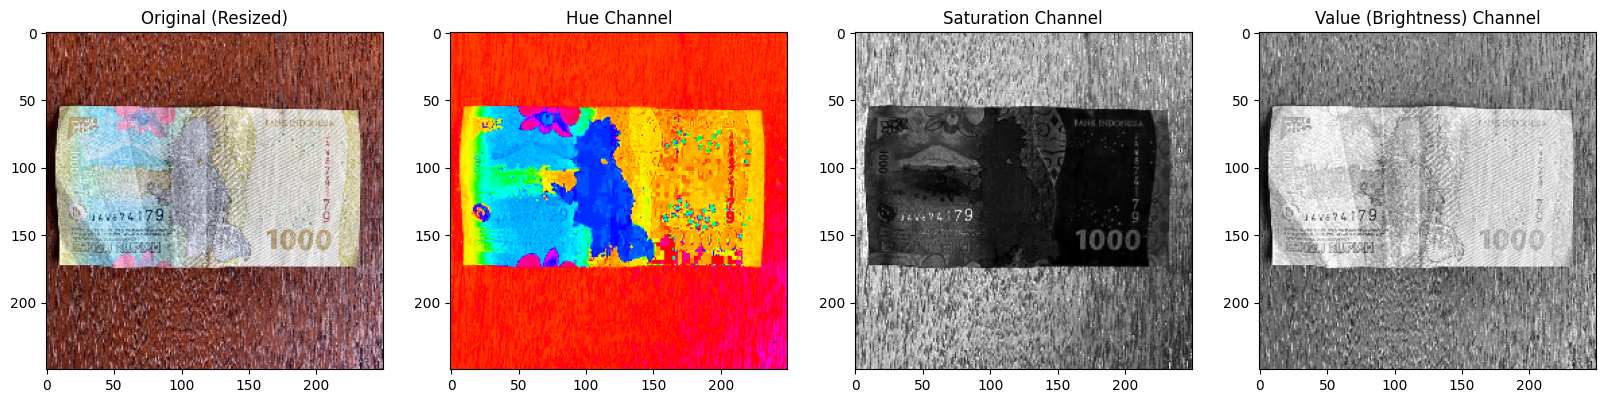

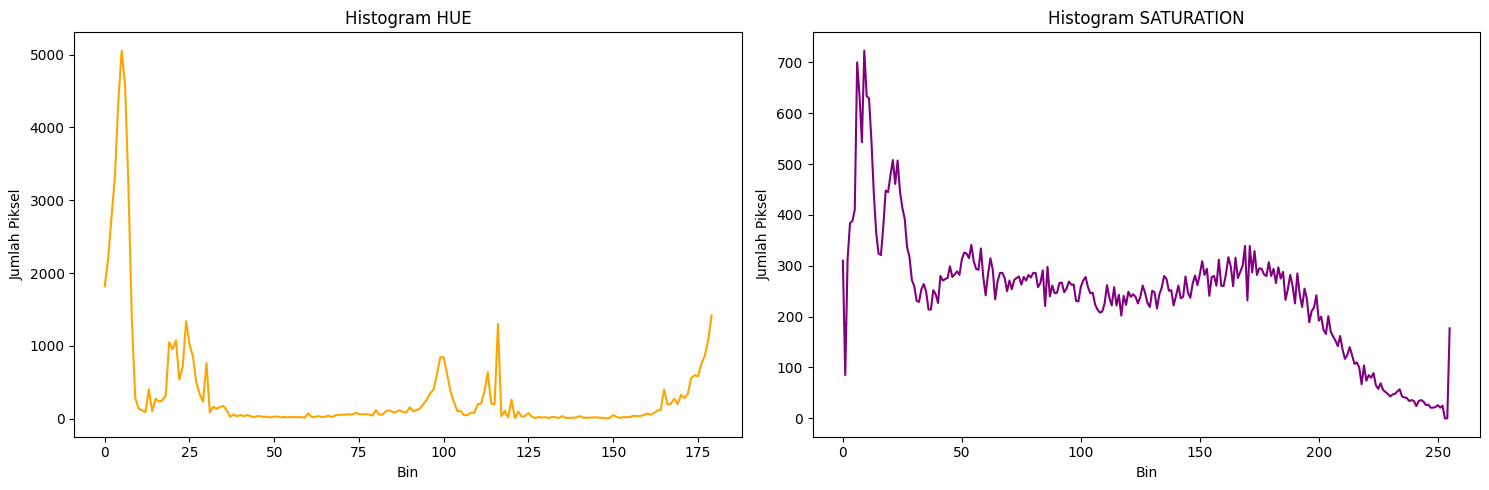

In [ ]:
# -----------------------------------------------------
# LANGKAH 7: (OPSIONAL) VISUALISASI CONTOH
# -----------------------------------------------------

if total_images > 0:
    print("\nVisualisasi contoh:")
    try:
        # Ambil satu gambar contoh dari data Anda
        sample_label = None
        for lbl in LABELS:
            if data_counts[lbl] > 0:
                sample_label = lbl
                break

        if sample_label:
            sample_img_name = os.listdir(os.path.join(BASE_DIR, sample_label))[0]
            sample_path = os.path.join(BASE_DIR, sample_label, sample_img_name)

            # Baca dan proses
            img = cv2.imread(sample_path)
            img_resized = cv2.resize(img, IMG_SIZE)
            img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)

            # Ambil channel H, S, V
            h, s, v = cv2.split(img_hsv)

            # Tampilkan
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))

            axs[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Original (Resized)')

            axs[1].imshow(h, cmap='hsv')
            axs[1].set_title('Hue Channel')

            axs[2].imshow(s, cmap='gray')
            axs[2].set_title('Saturation Channel')

            axs[3].imshow(v, cmap='gray')
            axs[3].set_title('Value (Brightness) Channel')

            plt.show()

            # Tampilkan histogramnya
            h_hist = cv2.calcHist([img_hsv], [0], None, [H_BINS], [0, 180])
            s_hist = cv2.calcHist([img_hsv], [1], None, [S_BINS], [0, 256])

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 2, 1)
            plt.plot(h_hist, color='orange')
            plt.title('Histogram HUE')
            plt.xlabel('Bin')
            plt.ylabel('Jumlah Piksel')

            plt.subplot(1, 2, 2)
            plt.plot(s_hist, color='purple')
            plt.title('Histogram SATURATION')
            plt.xlabel('Bin')
            plt.ylabel('Jumlah Piksel')

            plt.tight_layout()
            plt.show()
        else:
            print("Tidak ada gambar contoh untuk divisualisasikan.")

    except Exception as e:
        print(f"Tidak bisa membuat visualisasi: {e}")